# Logging of the project

In this notebook you will find all the steps it took us to acurately predict the temperature of nuclear waste canister. 

### **Imports** 

In [1]:
## data handling 
import numpy as np
import pandas as pd

## plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## ML things
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
import functions as func
from sklearn.model_selection import GridSearchCV

## comfort things
from typing import Tuple
from sys import exit

### **Loading of the datasets** 

In [2]:
coordinates_pred = pd.read_csv("data/Coordinates_Test.csv")
coordinates_train = pd.read_csv("data/Coordinates_Training.csv")
humidity_pred = pd.read_csv("data/Test_Time_humidity.csv")
humidity_train = pd.read_csv("data/Training_data_humidity.csv")
pressure_pred = pd.read_csv("data/Test_Time_pressure.csv")
pressure_train = pd.read_csv("data/Training_data_pressure.csv")
temperature_train = pd.read_csv("data/Training_data_temperature.csv")

Let's get the sensor IDs in a list before some of them are deleted, and also the time stamps:

In [3]:
sensor_IDs = pressure_train.columns[1:]

## Chech that none is missing: 
for i, sens in enumerate(sensor_IDs):
    assert 'N_'+str(i+1) == sens

time: list = pressure_train['M.Time[d]'].to_list()

### **Imputing the datasets**


Actually, the sensor N_442 has not temperature values so as the data must coordinate well with the indices, we will remove it as well as other sensors with no data from all the datasets.

<font color="red"> I need to verify how the sklearn KNN imputer works as I thin it copies values from other sensors instead of at another time ! 

In [4]:
imputer = KNNImputer(missing_values = np.nan, n_neighbors = 2).set_output(transform="pandas")

## The imputer actually deletes columns with no data so we need to identify the columns with no data first
## We need to know those sensors to remove the associated data in the other dataframes. 
## It is needed because the values are only linked by having the same index in all dataframes.

train_faulty_sensors = []
for sensor in pressure_train.columns[1:]:
    if temperature_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif pressure_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif humidity_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
print(f'Faulty sensors in train datasets: {train_faulty_sensors}')

test_faulty_sensors = []
for sensor in pressure_pred.columns[1:]:
    if pressure_pred[sensor].isna().all():
        test_faulty_sensors.append(sensor)
    elif humidity_pred[sensor].isna().all():
        test_faulty_sensors.append(sensor)
print(f'Faulty sensors in prediction datasets: {test_faulty_sensors}')
# Actually no sensors in the test dataset has no data

## Deleting the corresponding entries in all training datasets:
# we have to work with indices when dealing with rows...
# used ChatGPT to get this heavy syntax and might not be efficient...
 
## We will remove the corresponding data as it's only 3 points. 
## But keep the coordinates of the faulty sensor so we have a 
# pressure_train.drop(train_faulty_sensors, axis=1, inplace=True)
# humidity_train.drop(train_faulty_sensors, axis=1, inplace=True)
# temperature_train.drop(train_faulty_sensors, axis=1, inplace=True)

## We need to impute the missing values with a KNN imputer so it can be plotted a first time: 
## Which requires renaming the columns: 

## Not keeping useless columns:
coordinates_train = coordinates_train[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
coordinates_pred = coordinates_pred[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
# The sensor ID will be usefull to group the data into a numpy array

# changing the column names for faster typing later
new_col_names: dict = {
    "Sensor ID": "id",
    "Coor X [m]": "x",
    "Coor Y [m]": "y",
    "Coor Z [m]": "z",
    "R [m]": "r"
}

coordinates_train.rename(columns = new_col_names, inplace=True)
coordinates_pred.rename(columns = new_col_names, inplace=True)

pressure_train = func.fill_NaN_columns(
    K = 5,
    df = pressure_train,
    data_no_nan = imputer.fit_transform(pressure_train),
    coords = coordinates_train
)

pressure_pred = func.fill_NaN_columns(
    K = 5,
    df = pressure_pred,
    data_no_nan = imputer.fit_transform(pressure_pred),
    coords = coordinates_pred
)

Faulty sensors in train datasets: ['N_442', 'N_518', 'N_693']
Faulty sensors in prediction datasets: []


#### **Coordinates**

In [5]:
display(coordinates_train.sample(5))
coordinates_train.info()
coordinates_train["Material"].unique()

,id,Material,x,y,z,r
556,N_557,BBLOCK,0.319451,29.591669,-0.715480,0.783557
856,N_857,OPA,-1.306057,21.854072,3.003130,3.274840
764,N_765,OPA,2.875741,24.191359,-1.508841,3.247536
126,N_127,OPA,-14.139091,40.778022,-10.555972,17.644898
898,N_899,CAN,-0.484575,28.633740,-0.182562,0.517824


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        900 non-null    object 
 1   Material  900 non-null    object 
 2   x         900 non-null    float64
 3   y         900 non-null    float64
 4   z         900 non-null    float64
 5   r         900 non-null    float64
dtypes: float64(4), object(2)
memory usage: 42.3+ KB


array(['OPA', 'SHCR', 'GBM', 'EDZ', 'VOID', 'CAN', 'BBLOCK'], dtype=object)

We can see there are no missing data and apparently no false measures (outliers) on the position and the material, but some columns are useless like the numbering of rows and the index. Because the rows are in an ascending order and as long as the indices match between the files, the number doesn't matter. We are also renaming the columns to make it easier later.  

We will also one-hot encode the Material column to feed it later in the model, as they are caterogical features. 

In [6]:

## One-hot encoding:
## cf intro to pandas notebook from the weekly exercises
coordinates_pred = pd.get_dummies(coordinates_pred, columns = ["Material"]) 
coordinates_train = pd.get_dummies(coordinates_train, columns = ["Material"]) 
display(coordinates_pred.head(5))
display(coordinates_train.head(5))

## the coordinates_pred is missing the columns "Material_BBLOCK" and "Material_VOID" that we have to add 
# Make a copy to be safe
df = coordinates_pred.copy()
# Create the new column with default value (e.g., 0 or NaN)
df["Material_BBLOCK"] = False  # or use np.nan if needed
df["Material_VOID"] = False
# Get column list and rearrange
cols = df.columns.tolist()
# Find index of "r"
r_index = cols.index("r")
# Insert "Material_BBLOCK" right after "r"
cols.insert(r_index + 1, cols.pop(cols.index("Material_BBLOCK")))
# Reorder the DataFrame
coordinates_pred = df[cols]


display(coordinates_pred.head(5))


,id,x,y,z,r,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR
0,N_901,0.295918,30.011150,1.776254,1.800735,False,False,False,True,False
1,N_902,2.274456,25.204297,2.957595,3.731021,False,False,False,True,False
2,N_903,-0.586165,27.600980,-1.869516,1.959255,False,False,False,True,False
3,N_904,-1.680052,40.394076,-0.297226,1.706142,False,True,False,False,False
4,N_905,2.840656,38.093588,2.125899,3.548066,False,False,False,True,False


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR,Material_VOID
0,N_1,0.208042,14.436936,-2.875503,2.883019,False,False,False,False,True,False,False
1,N_2,-8.970832,28.229841,-0.134437,8.971839,False,False,False,False,True,False,False
2,N_3,-14.289501,6.685726,-10.399048,17.672862,False,False,False,False,True,False,False
3,N_4,6.114855,2.685645,-3.189981,6.896914,False,False,False,False,True,False,False
4,N_5,4.048845,48.708590,11.260503,11.966289,False,False,False,False,True,False,False


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR,Material_VOID
0,N_901,0.295918,30.011150,1.776254,1.800735,False,False,False,False,True,False,False
1,N_902,2.274456,25.204297,2.957595,3.731021,False,False,False,False,True,False,False
2,N_903,-0.586165,27.600980,-1.869516,1.959255,False,False,False,False,True,False,False
3,N_904,-1.680052,40.394076,-0.297226,1.706142,False,False,True,False,False,False,False
4,N_905,2.840656,38.093588,2.125899,3.548066,False,False,False,False,True,False,False


#### **Pressure**

In [7]:
display(pressure_train.head(5))
pressure_train.isnull().sum().sum() # See how many missing values there are

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554,281.143955,1462.382827,1656.041967,1322.584393,1473.656845,1480.325846,1650.794639,1511.445756,1397.850463,...,-57423.47996,202.296319,395.883971,651.026983,-405.358355,-60428.68990,-768.389510,336.655683,-63100.53626,831.154054
1,1556,279.968800,1461.806069,1656.007440,1322.251688,1473.611215,1480.290558,1650.692513,1511.327468,1397.594172,...,-57398.67576,201.782481,395.553760,649.949956,-405.782281,-60422.76359,-769.736168,335.531920,-63004.35183,830.963631
2,1558,278.797310,1461.224531,1655.972023,1321.919350,1473.565180,1480.255784,1650.589484,1511.207764,1397.338620,...,-57373.82834,201.470400,395.458253,648.902434,-405.531701,-60416.87545,-771.054710,334.539419,-62924.41589,830.870655
3,1560,277.631157,1460.639147,1655.935750,1321.587287,1473.518663,1480.221507,1650.485576,1511.086587,1397.083769,...,-57348.80938,201.459983,395.687942,647.909216,-404.343841,-60411.01323,-772.329622,333.773806,-62855.88550,830.915078
4,1563,275.898544,1459.753528,1655.879443,1321.089332,1473.447601,1480.170896,1650.327726,1510.901301,1396.702138,...,-57310.61967,202.456185,397.004063,646.629125,-400.066605,-60402.23717,-774.086664,333.414898,-62770.54127,831.441631


0

No missing value here, actually there was some but they were related to faulty sensors we deleted previously.  

First we will handle outliers

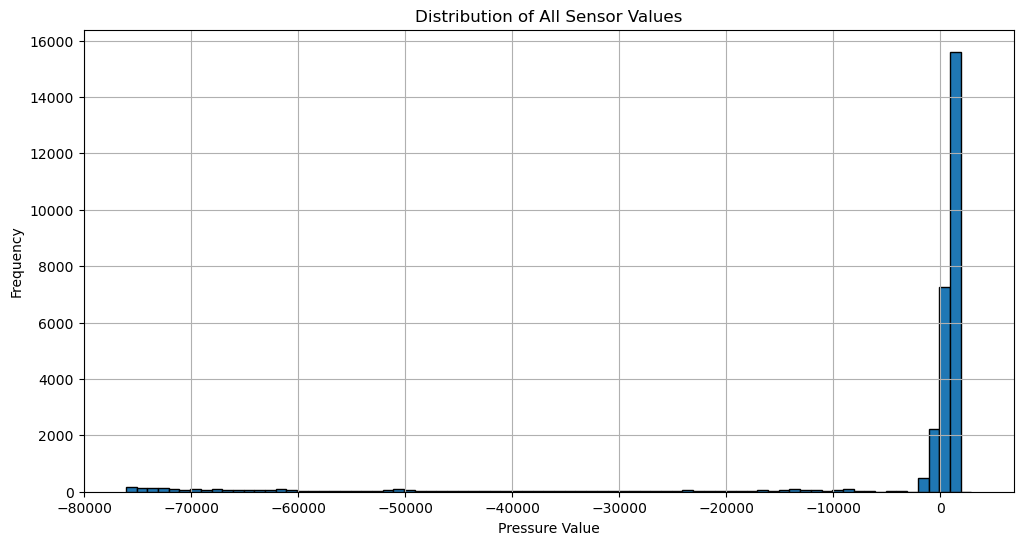

-4595.805803237333
17488.72888179162


In [8]:
# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1000, 1000), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(np.mean(all_values))
print(np.std(all_values))

We clearly have false measures in our data as there is no trend in those large negative values and a very small frequency. To fix this, we will apply a low filter at -3'000. Once we delete this data, we'll try not to delete the whole column/row as it would remove quite a lot of data. So we prefer to impute the missing data, we could use constant or mean imputation but we'll use KNN imputation to replace them, with 2 neighbors as it will more likely preserve the time continuation.  
<font color="red"> should we remove outliers from the test data ? It seems not very clever to try predicting false values...

pressure_train shape:(32, 901)
pressure_pred shape:(32, 146)
146 columns in pressure_train are filled with NaN
32 columns in pressure_pred are filled with NaN
pressure_train shape:(32, 901)
pressure_pred shape:(32, 146)


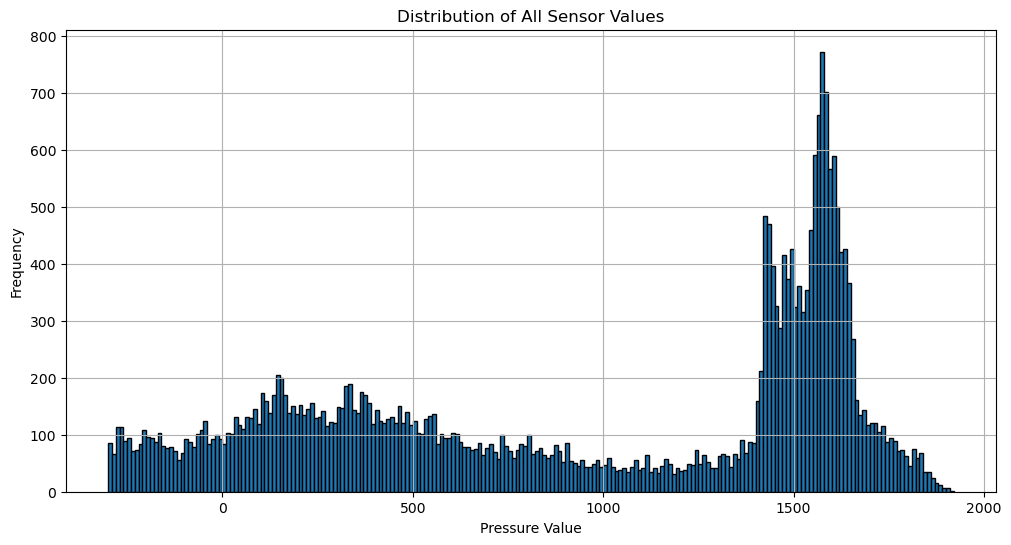

Mean: 947.3862271904371
SD: 657.3134285054718


In [9]:

## clearing values below -3'000:
pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] <= -300, np.nan) ## changed to -100 to see
pressure_pred.iloc[:,1:] = pressure_pred.iloc[:,1:].mask(pressure_pred.iloc[:,1:] <= -300, np.nan)

## Initial shapes
print("pressure_train shape:"+str(pressure_train.shape))
print("pressure_pred shape:"+str(pressure_pred.shape))

## Checking how many columns are filled with NaN values
count = pressure_train.isnull().all().sum()
print(f'{count} columns in pressure_train are filled with NaN')
count = pressure_pred.isnull().all().sum()
print(f'{count} columns in pressure_pred are filled with NaN')

## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
pressure_train = func.fill_NaN_columns(
    K = 5,
    df = pressure_train,
    data_no_nan = imputer.fit_transform(pressure_train),
    coords = coordinates_train
)

pressure_pred = func.fill_NaN_columns(
    K = 5,
    df = pressure_pred,
    data_no_nan = imputer.fit_transform(pressure_pred),
    coords = coordinates_pred
)

## Imputing missing values (if there are some):
pressure_train = imputer.fit_transform(pressure_train)
pressure_pred = imputer.fit_transform(pressure_pred)

## New shapes (should be the same)
print("pressure_train shape:"+str(pressure_train.shape))
print("pressure_pred shape:"+str(pressure_pred.shape))

# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 10, 10), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## New distribution parameters:
print(f'Mean: {np.mean(all_values)}')
print(f'SD: {np.std(all_values)}')


#### **Humidity**

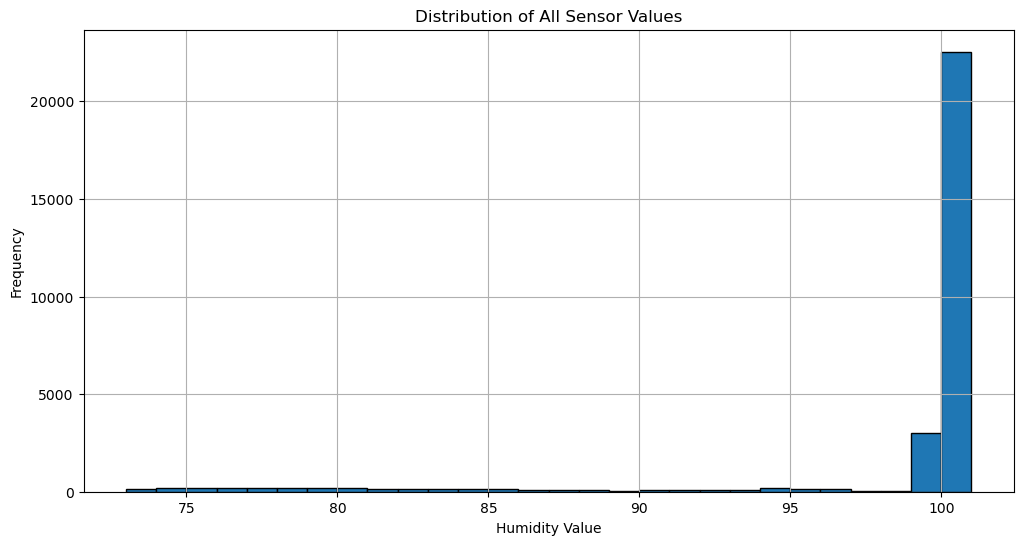

humidity_train shape:(32, 901)
humidity_pred shape:(32, 146)
0 columns in pressure_train are filled with NaN
0 columns in pressure_pred are filled with NaN


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,N_10,N_11,N_12
0,1554.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,1556.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,1558.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,1560.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,1563.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
5,1567.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
6,1572.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
7,1578.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
8,1585.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
9,1595.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [10]:
## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
humidity_train = func.fill_NaN_columns(
    K = 5,
    df = humidity_train,
    data_no_nan = imputer.fit_transform(humidity_train),
    coords = coordinates_train
)

humidity_pred = func.fill_NaN_columns(
    K = 5,
    df = humidity_pred,
    data_no_nan = imputer.fit_transform(humidity_pred),
    coords = coordinates_pred
)


## Imputing the missing data
humidity_train = imputer.fit_transform(humidity_train)
humidity_pred = imputer.fit_transform(humidity_pred)


# Visualize distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Initial shapes
print("humidity_train shape:"+str(humidity_train.shape))
print("humidity_pred shape:"+str(humidity_pred.shape))

## Checking how many columns are filled with NaN values
count = humidity_train.isnull().all().sum()
print(f'{count} columns in pressure_train are filled with NaN')
count = humidity_pred.isnull().all().sum()
print(f'{count} columns in pressure_pred are filled with NaN')


## Imputing the missing data
humidity_train = imputer.fit_transform(humidity_train)
humidity_pred = imputer.fit_transform(humidity_pred)

display(humidity_train.iloc[:,0:13])

There are some values that appear rarely but they are very realistic so we decided not to clip them.

#### **Temperature**

In [11]:
display(temperature_train.head(5))
print(temperature_train.shape)

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554,17.623059,17.154220,17.641578,17.455701,NaN,16.604935,17.662407,16.503001,16.943823,...,17.503931,17.225297,17.498277,17.268529,17.573474,17.412215,17.526257,17.364940,24.026562,17.538194
1,1556,17.620860,17.154263,17.641672,17.455850,16.415312,16.605042,17.662519,16.503121,16.943985,...,17.510776,17.223290,17.498581,17.267488,17.578925,17.409841,17.522860,17.363663,33.729552,17.537460
2,1558,17.618608,17.154303,17.641766,17.455998,16.415377,16.605148,17.662632,16.503240,16.944146,...,17.534085,17.223733,17.501874,2872.837827,17.599256,17.407913,17.520157,17.363850,41.602481,17.537433
3,1560,17.616334,2717.706176,17.641859,17.456146,16.415440,16.605254,17.662744,16.503357,16.944307,...,17.581610,17.228355,17.509670,17.266326,17.640317,17.406770,17.518750,17.366504,48.218980,17.538652
4,1563,17.612991,17.154388,17.642000,17.456367,16.415531,16.605414,17.662912,16.503530,16.944544,...,17.723547,17.249726,17.535358,17.267759,17.757592,17.408069,17.521699,17.379102,56.258743,17.545154


(32, 901)


Here we notice sudden spikes in the temperature going from about 20 to 2'000+ (the mineral would most likely melt at that temperature) and going back down to 20 a few days later. We can consider those value as measurement errors. We can replace those outliers by the mean of the 2 nearest neighbors if they are above a threshold of 60 (we can see it should work well by looking at the graph below), this is called value cliping.

0


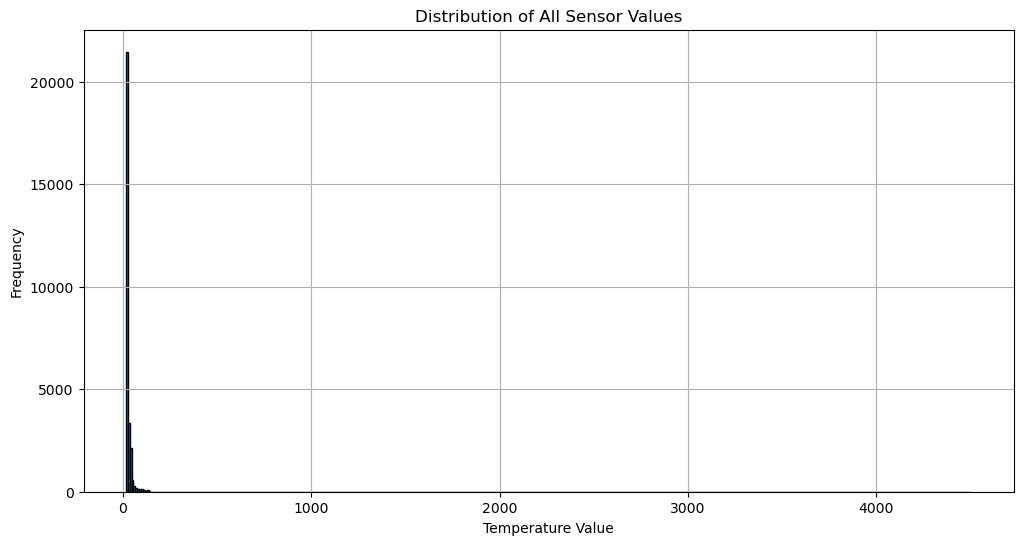

temperature_train shape: (32, 901)
empty columns: 0
temperature_train shape: (32, 901)


In [12]:
## It is essential to keep the dimensions so we will fill empty columns with values of the next column 
temperature_train = func.fill_NaN_columns(
    K = 5,
    df = temperature_train,
    data_no_nan = imputer.fit_transform(temperature_train),
    coords = coordinates_train
)

## We impute the missing data with the 2 nearest neighbors to view the distribution
temperature_train = imputer.fit_transform(temperature_train) 
print(temperature_train.isnull().sum().sum()) # check that it worked

# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = temperature_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 100, 10), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Applying the filter:
temperature_train.iloc[:,1:] = temperature_train.iloc[:,1:].mask(temperature_train.iloc[:,1:] >= 100, np.nan) ## set filter to 100 to see

## Initial shape: 
print(f'temperature_train shape: {temperature_train.shape}')
print(f'empty columns: {temperature_train.isnull().all().sum()}')

## We impute the missing data with the 2 nearest neighbors as done with the pressure
temperature_train = imputer.fit_transform(temperature_train)

## New shape: 
print(f'temperature_train shape: {temperature_train.shape}')

### **Feature engineering**

#### **Data normalization**

Data normalization is essential for a faster convergence of the descent methods and an appropriate penalization of the weights. We will use a z-score scaling technique as a min-max scaling would be scalled up by the few outliers left and concentrate the values too much. We'll then make sure the data is not too heavy-tailed for the scaling to work best.

In [13]:
## Mean and standard deviation are always computed on the training data
## axis = None computes the mean over the entire DataFrame with our current version of pandas: 2.0.3
## but it doesn't work with the std: 
#  https://stackoverflow.com/questions/25140998/pandas-compute-mean-or-std-standard-deviation-over-entire-dataframe

pressure_mean = pressure_train.iloc[:,1:].mean(axis=None) 
pressure_std = pressure_train.iloc[:,1:].values.std()

humidity_mean = humidity_train.iloc[:,1:].mean(axis=None) 
humidity_std = humidity_train.iloc[:,1:].values.std()

temperature_mean = temperature_train.iloc[:,1:].mean(axis=None)
temperature_std = temperature_train.iloc[:,1:].values.std()

coordinates_mean = coordinates_train[["x","y","z","r"]].mean(axis=0)
coordinates_std = coordinates_train[["x","y","z","r"]].std(axis=0)

# print(f'Mean pressure: {pressure_mean}')
# print(f'SD of pressure: {pressure_std}')

# print(f'Mean humidity: {humidity_mean}')
# print(f'SD of humidity: {humidity_std}')

# print(f'Mean temperature: {temperature_mean}')
# print(f'SD of temperature: {temperature_std}')

pressure_train.iloc[:,1:] -= pressure_mean
pressure_train.iloc[:,1:] /= pressure_std
pressure_pred.iloc[:,1:] -= pressure_mean
pressure_pred.iloc[:,1:] /= pressure_std

humidity_train.iloc[:,1:] -= humidity_mean
humidity_train.iloc[:,1:] /= humidity_std
humidity_pred.iloc[:,1:] -= humidity_mean
humidity_pred.iloc[:,1:] /= humidity_std

temperature_train.iloc[:,1:] -= temperature_mean
temperature_train.iloc[:,1:] /= temperature_std

coordinates_train[["x","y","z","r"]] -= coordinates_mean
coordinates_train[["x","y","z","r"]] /= coordinates_std
coordinates_pred[["x","y","z","r"]] -= coordinates_mean
coordinates_pred[["x","y","z","r"]] /= coordinates_std

## Check that the values now follow a normal distribution : 
## (the test sets will be off obviously)
assert np.isclose(pressure_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(pressure_train.iloc[:,1:].values.std(), 1)

assert np.isclose(humidity_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(humidity_train.iloc[:,1:].values.std(), 1)

assert np.isclose(temperature_train.iloc[:,1:].mean(axis=None), 0)
assert np.isclose(temperature_train.iloc[:,1:].values.std(), 1)

assert np.allclose(coordinates_train[["x","y","z","r"]].mean(axis=0), 0)
assert np.allclose(coordinates_train[["x","y","z","r"]].std(axis=0), 1)



Let's visualize our data before making it into numpy arrays :

In [14]:
display(pressure_train.head(5))
display(humidity_train.head(5))
display(coordinates_train.head(5))
display(temperature_train.head(5))

print(f"Pressure's shape: {pressure_train.shape}")
print(f"Humidity's shape: {humidity_train.shape}")
print(f"Coordinates' shape: {coordinates_train.shape}")
print(f"Temperature's shape: {temperature_train.shape}")

## Verify that we no longer have missing values: 
assert pressure_train.isnull().any().sum() == 0
assert pressure_pred.isnull().any().sum() == 0
assert humidity_train.isnull().any().sum() == 0
assert humidity_pred.isnull().any().sum() == 0
assert coordinates_train.isnull().any().sum() == 0
assert coordinates_pred.isnull().any().sum() == 0
assert temperature_train.isnull().any().sum() == 0

,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554.0,-1.013584,0.783487,1.078109,0.570806,0.800639,0.810785,1.070126,0.858129,0.685311,...,-1.501042,-1.133538,-0.839025,-0.450864,-1.819832,-1.255086,-1.259280,-0.929131,-1.491088,-0.176829
1,1556.0,-1.015372,0.782610,1.078057,0.570299,0.800569,0.810731,1.069971,0.857949,0.684921,...,-1.502088,-1.134320,-0.839527,-0.452503,-1.819832,-1.256158,-1.261569,-0.930841,-1.492479,-0.177119
2,1558.0,-1.017154,0.781725,1.078003,0.569794,0.800499,0.810678,1.069814,0.857767,0.684532,...,-1.503073,-1.134795,-0.839672,-0.454097,-1.819832,-1.256936,-1.263843,-0.932351,-1.493490,-0.177260
3,1560.0,-1.018928,0.780834,1.077948,0.569289,0.800429,0.810626,1.069656,0.857582,0.684145,...,-1.503949,-1.134811,-0.839323,-0.455608,-1.819832,-1.257339,-1.266092,-0.933516,-1.493906,-0.177193
4,1563.0,-1.021564,0.779487,1.077862,0.568531,0.800320,0.810549,1.069416,0.857300,0.683564,...,-1.504832,-1.133295,-0.837321,-0.457555,-1.819832,-1.256972,-1.269360,-0.934062,-1.492665,-0.176392


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.400404,0.324866,0.324866,0.324866,0.295353,-3.573134,0.268955,0.324866,-3.644863,0.324866
1,1556.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.398901,0.324866,0.324866,0.324866,0.295323,-3.572826,0.268857,0.324866,-3.529004,0.324866
2,1558.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.397208,0.324866,0.324866,0.324866,0.295343,-3.572514,0.268761,0.324866,-3.439484,0.324866
3,1560.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.395231,0.324866,0.324866,0.324866,0.295434,-3.572195,0.268668,0.324866,-3.367152,0.324866
4,1563.0,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,0.324866,...,-3.391427,0.324866,0.324866,0.324866,0.295757,-3.571681,0.268541,0.324866,-3.282594,0.324866


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR,Material_VOID
0,N_1,0.016937,-1.027975,-0.380302,-0.860992,False,False,False,False,True,False,False
1,N_2,-1.210408,0.141186,-0.016204,0.084301,False,False,False,False,True,False,False
2,N_3,-1.921589,-1.685009,-1.379661,1.435142,False,False,False,False,True,False,False
3,N_4,0.806761,-2.024077,-0.422075,-0.237832,False,False,False,False,True,False,False
4,N_5,0.530507,1.877074,1.497395,0.549192,False,False,False,False,True,False,False


,M.Time[d],N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,...,N_891,N_892,N_893,N_894,N_895,N_896,N_897,N_898,N_899,N_900
0,1554.0,-0.484976,-0.518658,-0.483646,-0.496999,-0.557497,-0.558118,-0.482150,-0.565441,-0.533773,...,-0.493535,-0.513552,-0.493941,-0.510446,-0.488539,-0.500123,-0.491931,-0.503520,-0.024949,-0.491073
1,1556.0,-0.485134,-0.518655,-0.483639,-0.496989,-0.571741,-0.558111,-0.482142,-0.565433,-0.533761,...,-0.493043,-0.513696,-0.493919,-0.510521,-0.488147,-0.500294,-0.492175,-0.503611,0.672114,-0.491126
2,1558.0,-0.485296,-0.518652,-0.483633,-0.496978,-0.571736,-0.558103,-0.482134,-0.565424,-0.533750,...,-0.491368,-0.513664,-0.493682,-0.510483,-0.486686,-0.500433,-0.492369,-0.503598,1.237705,-0.491128
3,1560.0,-0.485460,-0.518649,-0.483626,-0.496968,-0.571732,-0.558096,-0.482125,-0.565416,-0.533738,...,-0.487954,-0.513332,-0.493122,-0.510604,-0.483737,-0.500515,-0.492470,-0.503407,1.713034,-0.491040
4,1563.0,-0.485700,-0.518646,-0.483616,-0.496952,-0.571725,-0.558084,-0.482113,-0.565403,-0.533721,...,-0.477757,-0.511797,-0.491277,-0.510501,-0.475312,-0.500421,-0.492258,-0.502502,2.290611,-0.490573


Pressure's shape: (32, 901)
Humidity's shape: (32, 901)
Coordinates' shape: (900, 12)
Temperature's shape: (32, 901)


##### **Visualizing the data**

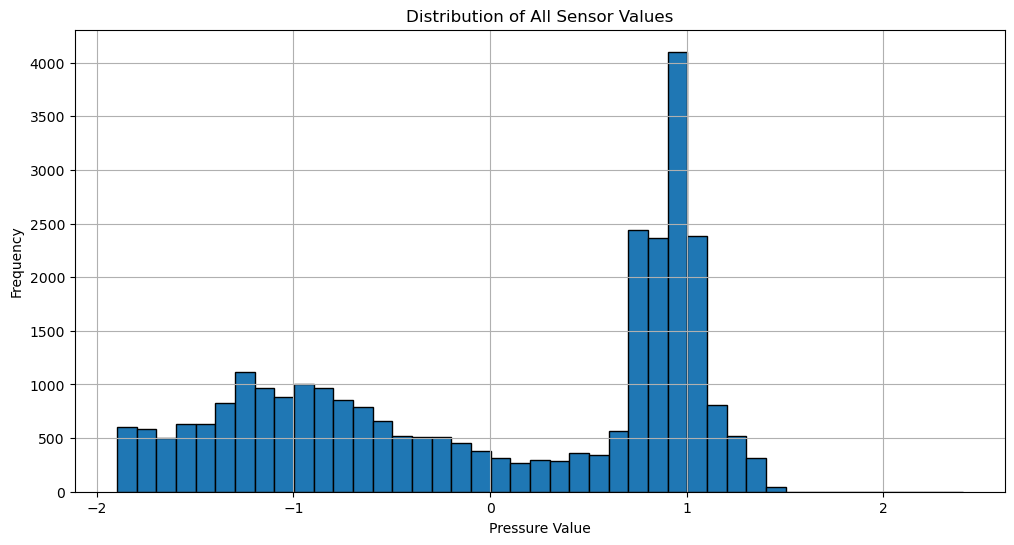

In [15]:
# Visualize distribution with a histogram again(code provided by ChatGPT)
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

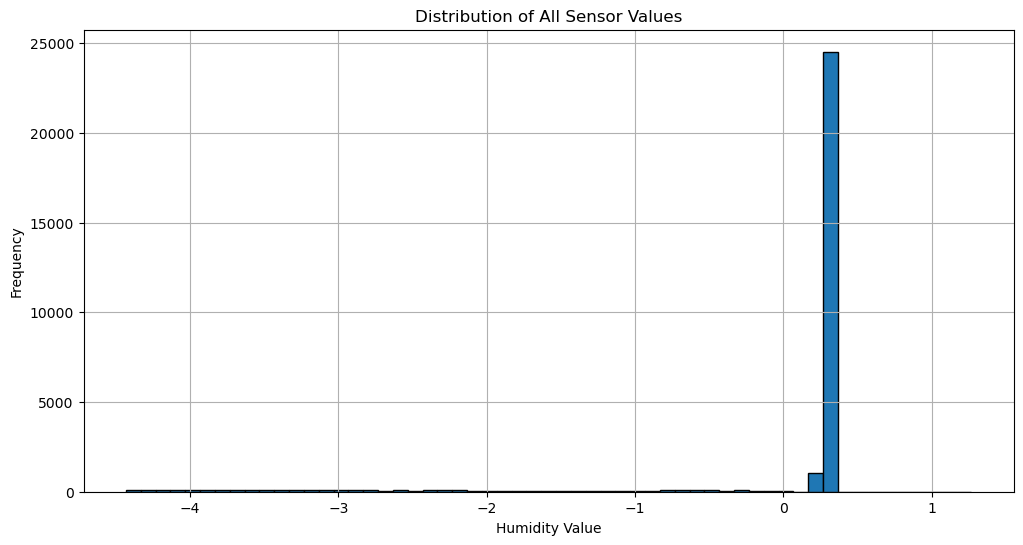

In [16]:
# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = humidity_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

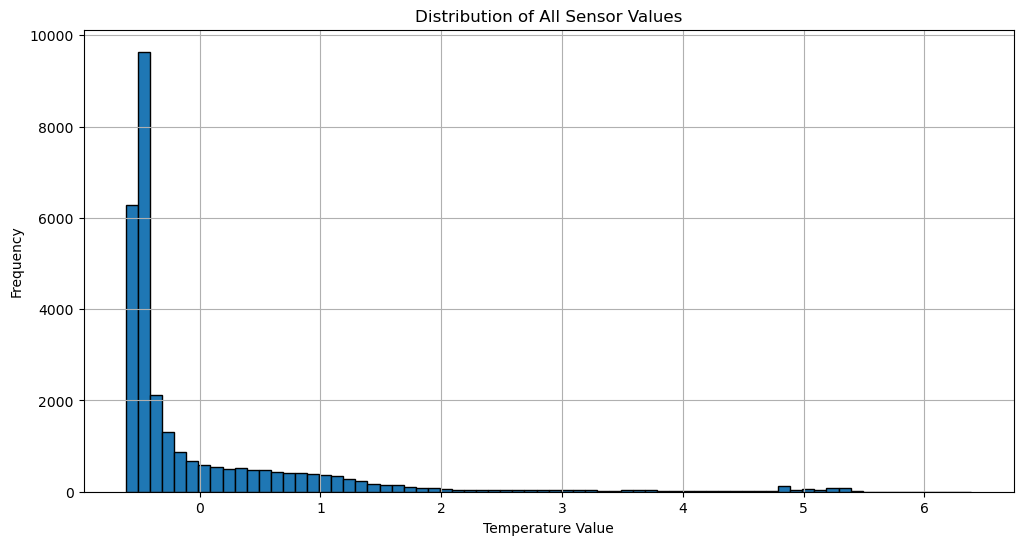

In [17]:
# Visualize the distribution with a histogram (code provided by ChatGPT)
sensor_data = temperature_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(12, 6))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 0.1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Text(0.5, 0.92, '3D Temperature Distribution')

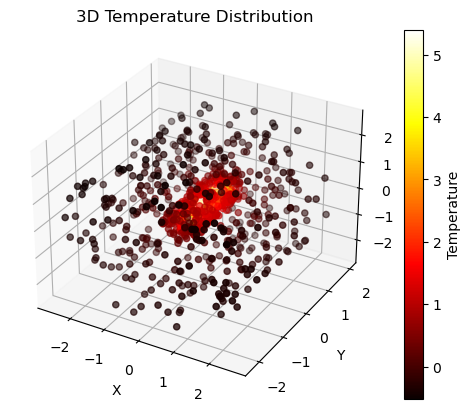

In [18]:
# # To plot the graph we have to remove faulty sensors from the position too so the dimensions match. 
# coordinates_train.drop(coordinates_train[coordinates_train["id"].isin(train_faulty_sensors)].index, inplace=True)

T = temperature_train.iloc[-1,1:].to_numpy()
x = coordinates_train["x"].to_numpy()
y = coordinates_train["y"].to_numpy()
z = coordinates_train["z"].to_numpy()

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=T, cmap='hot', marker='o')

# Add colorbar to show temperature scale
plt.colorbar(sc, label='Temperature')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Temperature Distribution')


All the chapes are matching, we can assume that indices match between each DataFrame

#### **Splitting data**  

We will first split the data into 3 sets with an arbitrary split: 
- Train set
- Validation set 
- Test set  

Later we'll implement a cross-validation for a better training.

In [47]:
## The idea is to have a DataFrame for each time stamp as follows: 

#           | pressure | humidity | x | y | z | r |  materials... |
# ----------+----------+----------+---+---+---+---+---------------+
# N_1       |          |          |   |   |   |   |               |
# ...       |          |          |   |   |   |   |               |
# N_897     |          |          |   |   |   |   |               |

X_t: dict = {}
y_t: dict = {}

for i, t in enumerate(pressure_train['M.Time[d]']): 
    ## first, selsect the pressure data at the time
    X = pressure_train.iloc[i, 1:]
    H = humidity_train.iloc[i,1:]
    ## then transpose as we need the sensor as rows, not columns
    X = X.T
    H = H.T
    X = np.reshape(X, (X.shape[0], 1)) # for some reason it didn't work without reshaping to (n, 1)
    H = np.reshape(H, (H.shape[0], 1))
    ## then add the coordinates and material features to the array 
    coords = coordinates_train.iloc[:,1:].to_numpy()
    X = np.concatenate([X,H,coords], axis = 1)
    ## add it to the dictionnary
    X_t[t] = X

for i, t in enumerate(time): 
    y = temperature_train.iloc[i, 1:]
    y_t[t] = y.to_numpy()

## defining the number of features (useful later for the NN):
n_features = X_t[1554].shape[1]
print(n_features)

## Splitting the data into training, validation and test: fixed ratios 60%, 20% & 20% respectively (code by ChatGPT)
# Step 1: Shuffle the keys
keys = list(X_t.keys())
keys = shuffle(keys)  # Set random_state for reproducibility 

# Step 2: Compute split indices
n = len(keys)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

# Step 3: Split keys
train_keys = keys[:train_end]
val_keys = keys[train_end:val_end]
test_keys = keys[val_end:]

# Step 4: Create new dictionaries
X_train = {k: X_t[k] for k in train_keys}
X_val   = {k: X_t[k] for k in val_keys}
X_test  = {k: X_t[k] for k in test_keys}
y_train = {k: y_t[k] for k in train_keys}
y_val   = {k: y_t[k] for k in val_keys}
y_test  = {k: y_t[k] for k in test_keys}


13


### **Creating the model**  

For this project we will first try to use a vanilla neural network

#### **Imports**

In [20]:
# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Progress bar
from tqdm.auto import tqdm

# metrics
import metrics


#### **The model**

In [21]:
class VanillaNN(nn.Module):
    """2-Layers Vanilla Neural Network"""
    
    def __init__(self, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(n_features,n_features)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(n_features,n_features)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(n_features,1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.tanh(self.fc1(x))
        out = self.fc2(out)
        out = F.leaky_relu(out, negative_slope=0.01, inplace=True)
        out = self.fc3(out)
        return out

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

model = VanillaNN(dropout_rate=0.5)

## Loss & Optimizer:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.01) # weight decay is the regularization strenght

### **Training**
  
Each timestamp represents an epoch: data of the ~900 sensors.

In [22]:
def train(
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        time: list,
        X_train: dict, 
        y_train: dict,
        epochs = 5
):

    # Initialize metrics for loss and accuracy:
    loss_metric = metrics.LossMetric()
    acc_metric = metrics.AccuracyMetric(k=1)

    ## set the module into training mode: 
    model.train()

    for epoch in range(1, epochs+1):

        ## Set up the progress bar: 
        pbar = tqdm(total=28704, leave=True)
        pbar.set_description(f"epoch: {epoch}")

        for t in time:

            X = X_t[t]
            y = y_t[t]

            ## Iterate through the data:
            for i in range(X.shape[0]):

                data = torch.from_numpy( np.array( X[i,:], dtype=np.float32 ) ) 
                data = data.unsqueeze(0)  # shape becomes (1, n_features): it is needed for nn.Linear
                target = torch.from_numpy( np.array( y[i], dtype=np.float32 ) )
                target = target.view(1,1)

                # Zero-out the gradients
                optimizer.zero_grad()

                # Forward pass
                out = model(data)

                # Compute loss
                loss = loss_fn(out, target)

                # Backward pass
                loss.backward()
                
                # Optimizer step
                optimizer.step()

                # Update metrics & progress bar
                loss_metric.update(loss.item(), data.shape[0])
                # acc_metric.update(out, target)
                pbar.update()
                
        # End of epoch, show loss and acc
        pbar.set_postfix_str(f"Train loss: {loss_metric.compute():.3f}")
        loss_metric.reset()
        # acc_metric.reset()
                

In [23]:
train(
    model, 
    optimizer,
    loss_fn,
    time,
    X_train,
    y_train,
    epochs = 6
)

## best loss: 0.075

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

### **Validation**

Regarding the model:
- type of architecture -> Already did (added 1 layer)
- Batch normalization
- Randomly drop neurons

True hyperparameters:
- Number of neighbours in the NKK data preparation -> in progress
- Type of regularization
- Weights_decay (alpha) -> Done
- Learning rate -> Already did
- Hyperparameters search in log scale

<font color="red"> 109 score was achieved by having dropout rate fixed at 0.5, without searching its best value (when I did it, the result deteriorated)

In [24]:
def validate(
        model: torch.nn.Module, 
        loss_fn: torch.nn.Module, 
        X_val: dict, 
        y_val: dict,
        time: list
) -> float:
    """Validate the model and return the average loss."""
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for t in time:
            # Skip segments that are not present in both dictionaries
            if t not in X_val or t not in y_val:
                print(f"Warning: Time segment {t} not found in validation set.")
                continue

            X = X_val[t]
            y = y_val[t]

            for i in range(X.shape[0]):
                data = torch.from_numpy(np.array(X[i, :], dtype=np.float32)).unsqueeze(0)
                target = torch.from_numpy(np.array(y[i], dtype=np.float32)).view(1, 1)

                # Forward pass
                out = model(data)
                loss = loss_fn(out, target)
                val_loss += loss.item()
                total_samples += 1

    # Calculate the average loss
    avg_val_loss = val_loss / total_samples if total_samples > 0 else float('inf')
    return avg_val_loss

1) Find the best learning rate

In [27]:
def grid_search_lr(
        model: torch.nn.Module, 
        optimizer_class: torch.optim.Optimizer, 
        loss_fn: torch.nn.Module,
        X_train: dict, 
        y_train: dict,
        X_val: dict, 
        y_val: dict,
        learning_rates: list, 
        epochs: int = 5
):
    """Perform grid search over learning rates and return the best learning rate."""
    best_lr = None
    best_val_loss = float('inf')
    results = {}

    # Extract time segments from validation set
    time_segments = list(X_val.keys())

    for lr in learning_rates:
        # Initialize model and optimizer
        model_copy = VanillaNN(dropout_rate=0.5)  # Reinitialize the model to avoid training on top of previous runs
        optimizer = optimizer_class(model_copy.parameters(), lr=lr)
        
        print(f"Testing learning rate: {lr}")

        # Train model
        train(model_copy, optimizer, loss_fn, time, X_train, y_train, epochs)

        # Validate model
        val_loss = validate(model_copy, loss_fn, X_val, y_val, time_segments)
        results[lr] = val_loss

        print(f"Learning Rate: {lr} - Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_lr = lr

    print(f"Best Learning Rate: {best_lr} - Validation Loss: {best_val_loss:.4f}")
    return best_lr, results

In [28]:
# Define learning rates to test
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# Example usage
best_lr, results = grid_search_lr(
    model,
    optim.SGD,
    loss_fn,
    X_train,
    y_train,
    X_val,
    y_val,
    learning_rates,
    epochs=3
)


Testing learning rate: 1e-05


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Learning Rate: 1e-05 - Validation Loss: 0.7555
Testing learning rate: 0.0001


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Learning Rate: 0.0001 - Validation Loss: 0.9865
Testing learning rate: 0.001


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Learning Rate: 0.001 - Validation Loss: 0.6832
Testing learning rate: 0.01


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Learning Rate: 0.01 - Validation Loss: 0.7152
Testing learning rate: 0.1


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Learning Rate: 0.1 - Validation Loss: nan
Best Learning Rate: 0.001 - Validation Loss: 0.6832


2) Search best regularization strenght

In [29]:
def grid_search_alpha(
        model: torch.nn.Module, 
        optimizer_class: torch.optim.Optimizer, 
        loss_fn: torch.nn.Module,
        X_train: dict, 
        y_train: dict,
        X_val: dict, 
        y_val: dict,
        weights_decay: list, 
        epochs: int = 5
):
    """Perform grid search over learning rates and return the best learning rate."""
    best_alpha = None
    best_val_loss = float('inf')
    results = {}

    # Extract time segments from validation set
    time_segments = list(X_val.keys())

    for alpha in weights_decay:
        # Initialize model and optimizer
        model_copy = VanillaNN(dropout_rate=0.5)  # Reinitialize the model to avoid training on top of previous runs
        optimizer = optimizer_class(model_copy.parameters(), lr=best_lr, weight_decay=alpha)
        
        print(f"Testing weights_decay: {alpha}")

        # Train model
        train(model_copy, optimizer, loss_fn, time, X_train, y_train, epochs)

        # Validate model
        val_loss = validate(model_copy, loss_fn, X_val, y_val, time_segments)
        results[alpha] = val_loss

        print(f"Weights_decay: {alpha} - Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_alpha = alpha

    print(f"Best weights_decay: {best_lr} - Validation Loss: {best_val_loss:.4f}")
    return best_alpha, results

In [37]:
# Define regularization strenght to test
weights_decay = [1e-3, 1e-2, 1e-1]

# Example usage
best_alpha, results = grid_search_alpha(
    model,
    optim.SGD,
    loss_fn,
    X_train,
    y_train,
    X_val,
    y_val,
    weights_decay,
    epochs=3
)


Testing weights_decay: 0.001


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Weights_decay: 0.001 - Validation Loss: 0.6749
Testing weights_decay: 0.01


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Weights_decay: 0.01 - Validation Loss: 0.7434
Testing weights_decay: 0.1


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Weights_decay: 0.1 - Validation Loss: 1.0050
Best weights_decay: 0.001 - Validation Loss: 0.6749


3. Search best dropout rate

In [38]:
def grid_search_dropout(
        model: torch.nn.Module, 
        optimizer_class: torch.optim.Optimizer, 
        loss_fn: torch.nn.Module,
        X_train: dict, 
        y_train: dict,
        X_val: dict, 
        y_val: dict,
        dropout_rates: list, 
        epochs: int = 5
):
    """Perform grid search over learning rates and return the best learning rate."""
    best_dropout = None
    best_val_loss = float('inf')
    results = {}

    # Extract time segments from validation set
    time_segments = list(X_val.keys())

    for dropout in dropout_rates:
        # Initialize model and optimizer
        model_copy = VanillaNN(dropout_rate=dropout)  # Reinitialize the model to avoid training on top of previous runs
        optimizer = optimizer_class(model_copy.parameters(), lr=best_lr, weight_decay=best_alpha)
        
        print(f"Testing dropout rate: {dropout}")

        # Train model
        train(model_copy, optimizer, loss_fn, time, X_train, y_train, epochs)

        # Validate model
        val_loss = validate(model_copy, loss_fn, X_val, y_val, time_segments)
        results[dropout] = val_loss

        print(f"Dropout rate: {dropout} - Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_dropout = dropout

    print(f"Best dropout rate: {best_dropout} - Validation Loss: {best_val_loss:.4f}")
    return best_dropout, results

In [40]:
# Define regularization strenght to test
dropout_rates = [0.1, 0.2, 0.5, 0.7]

# Example usage
best_dropout, results = grid_search_dropout(
    model,
    optim.SGD,
    loss_fn,
    X_train,
    y_train,
    X_val,
    y_val,
    dropout_rates,
    epochs=3
)

Testing dropout rate: 0.1


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Dropout rate: 0.1 - Validation Loss: 0.6550
Testing dropout rate: 0.2


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Dropout rate: 0.2 - Validation Loss: 0.6725
Testing dropout rate: 0.5


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Dropout rate: 0.5 - Validation Loss: 0.6842
Testing dropout rate: 0.7


  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

Dropout rate: 0.7 - Validation Loss: 0.6744
Best dropout rate: 0.1 - Validation Loss: 0.6550


The final step consist in injecting those parameters into the model and retraining the model

In [41]:
model = VanillaNN(dropout_rate=best_dropout)
optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=best_alpha) # weight decay is the regularization strenght

train(
    model, 
    optimizer,
    loss_fn,
    time,
    X_train,
    y_train,
    epochs = 6
)

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

  0%|          | 0/28704 [00:00<?, ?it/s]

### **Testing**

let's do only one prediction first to see how it goes

In [44]:
# lets try one prediction: 
import random
t = random.choice(time)
X = X_t[t]
y = y_t[t]
pred = []

for i in range(len(y)): 
    data = torch.from_numpy( np.array( X[i,:], dtype=np.float32 ) ) 
    pred.append(model(data).detach().numpy()[0])

print(np.array(pred)[:6])
print(y[:6])
print(func.MSE(pred,y))

[ 0.47301835 -0.01894379 -0.2956694  -0.2268945  -0.30808207 -0.336306  ]
[ 0.28176504  0.26592265 -0.34312707 -0.35898265 -0.38008789 -0.40885996]
0.08560397830051229


### **Making a submission**

In [45]:
X_t_pred = {}
sensor_IDs = pressure_pred.columns[1:]
pred = pd.DataFrame(data = sensor_IDs, columns=["id"])
display(pred)

for i, t in enumerate(pressure_pred['M.Time[d]']): 
    ## first, selsect the pressure data at the time
    X = pressure_pred.iloc[i, 1:]
    H = humidity_pred.iloc[i,1:]
    ## then transpose as we need the sensor as rows, not columns
    X = X.T
    H = H.T
    X = np.reshape(X, (X.shape[0], 1)) # for some reason it didn't work without reshaping to (n, 1)
    H = np.reshape(H, (H.shape[0], 1))

    ## then add the coordinates and material features to the array 
    coords = coordinates_pred.iloc[:,1:].to_numpy()
    X = np.concatenate([X,H,coords], axis = 1)
    ## add it to the dictionnary
    X_t_pred[t] = X

for t in pressure_pred["M.Time[d]"]:

    X = X_t_pred[t]
    y_i = []

    for i in range(X.shape[0]): 
        data = torch.from_numpy(np.array( X[i,:], dtype=np.float32 ) ) 
        y_i.append(model(data).detach().numpy()[0]*temperature_std + temperature_mean)

    pred[str(int(t))] = y_i
    y_i.clear()

display(pred)
pred.to_csv("data\\submission.csv", index=False)

,id
0,N_901
1,N_902
2,N_903
3,N_904
4,N_905
...,...
140,N_1042
141,N_1043
142,N_1044
143,N_1045


,id,1554,1556,1558,1560,1563,1567,1572,1578,1585,...,2395,2607,2871,3202,3616,4133,4779,5587,6597,7028
0,N_901,46.973826,46.973786,46.973580,46.973519,46.973773,46.974669,46.976531,46.979917,46.986518,...,47.191751,47.129563,47.090194,47.044595,46.989832,46.940614,46.896446,46.852025,46.807877,46.791663
1,N_902,40.417638,40.421122,40.424576,40.427931,40.432451,40.436880,40.438924,40.435496,40.423328,...,39.645548,39.817290,40.019881,40.242647,40.478975,40.722423,40.958377,41.184464,41.381307,41.445914
2,N_903,48.455733,48.455068,48.454633,48.454517,48.454630,48.458805,48.467692,48.482755,48.504706,...,48.926360,48.847327,48.740384,48.627075,48.513392,48.430340,48.335510,48.242587,48.159686,48.129917
3,N_904,34.337377,34.333987,34.330921,34.328455,34.327017,34.330703,34.345621,34.378514,34.434955,...,36.521559,36.352013,36.147368,35.932188,35.793115,35.855582,36.035951,36.372252,36.793889,36.950718
4,N_905,30.244177,30.243290,30.242439,30.241663,30.240788,30.240390,30.241349,30.244664,30.251207,...,30.433248,30.378572,30.318084,30.255926,30.198038,30.151088,30.152611,30.257587,30.393811,30.435945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,N_1042,44.182838,44.182392,44.181977,44.181620,44.181287,44.181335,44.182237,44.184438,44.188219,...,44.255283,44.236721,44.215694,44.191596,44.165589,44.138332,44.109935,44.080066,44.048504,44.036251
141,N_1043,29.741368,29.740169,29.738983,29.737824,29.736212,29.734432,29.733081,29.733047,29.735388,...,30.051171,29.977076,29.879951,29.764080,29.637405,29.511372,29.399296,29.339586,29.408616,29.426758
142,N_1044,32.176437,32.177020,32.177568,32.178049,32.178489,32.178350,32.176875,32.173381,32.167632,...,32.138083,32.132231,32.134463,32.150119,32.184909,32.243855,32.330669,32.447225,32.577642,32.619588
143,N_1045,37.906757,37.907621,37.908406,37.909032,37.909392,37.908486,37.905056,37.898113,37.887482,...,37.815535,37.829043,37.852799,37.889919,37.943386,37.992035,38.043363,38.114963,38.010644,37.994046


145


Text(0.5, 0.92, '3D Temperature Distribution')

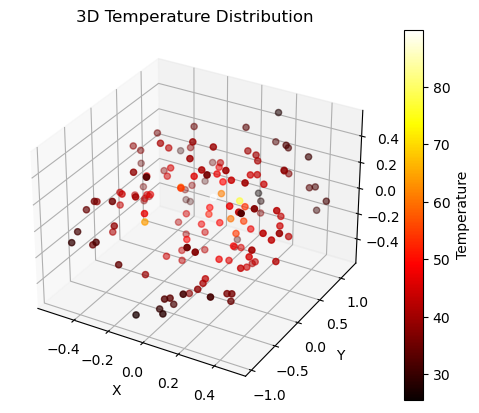

In [46]:
print(len(pred))
T = pred.iloc[:, -20].to_numpy()
x = coordinates_pred["x"].to_numpy()
y = coordinates_pred["y"].to_numpy()
z = coordinates_pred["z"].to_numpy()

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=T, cmap='hot', marker='o')

# Add colorbar to show temperature scale
plt.colorbar(sc, label='Temperature')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Temperature Distribution')